In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random

In [2]:
data = pd.read_csv('train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n] / 255

data_train = data[1000:].T
Y_train = data_train[0]
X_train = data_train[1:n] / 255

In [5]:
def init_params():
    """
    Initializes the weights and biases for a 3-layer neural network using He initialization.
    """
    W1 = np.random.randn(128, 784) * np.sqrt(2. / 784)
    b1 = np.zeros((128, 1))
    
    W2 = np.random.randn(64, 128) * np.sqrt(2. / 128)
    b2 = np.zeros((64, 1))
    
    W3 = np.random.randn(10, 64) * np.sqrt(2. / 64)
    b3 = np.zeros((10, 1))
    
    return W1, b1, W2, b2, W3, b3

def ReLU(Z):
    """
    Applies the ReLU activation function element-wise.
    """
    return np.maximum(0, Z) 

def softmax(Z):
    """
    Applies the softmax function to convert logits into probability distributions.
    """
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / np.sum(expZ, axis=0, keepdims=True)

def forward_prop(X, W1, b1, W2, b2, W3, b3):
    """
    Performs forward propagation through the neural network and returns intermediate values.
    """
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    
    return Z1, A1, Z2, A2, Z3, A3

def oneHot(Y):
    """
    Converts a vector of class labels into one-hot encoded format.
    """
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def derivReLU(Z):
    """
    Computes the derivative of the ReLU activation function.
    """
    return Z > 0

def back_prop(Z1, A1, Z2, A2, Z3, A3, X, Y, W2, W3):
    """
    Performs backpropagation to compute the gradients of the weights and biases.
    """
    m = Y.size
    one_hot_Y = oneHot(Y)
    
    # Backward for the first layer
    dZ3 = A3 - one_hot_Y
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True)
    
    # Backward for the second layer
    dZ2 = W3.T.dot(dZ3) * derivReLU(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    
    # Backward for the third layer
    dZ1 = W2.T.dot(dZ2) * derivReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2, dW3, db3


def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    """
    Updates the weights and biases using gradient descent with the computed gradients.
    """
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    W3 -= alpha * dW3
    b3 -= alpha * db3
    
    return W1, b1, W2, b2, W3, b3

In [6]:
def get_predictions(A2):
    """
    Returns the predicted class indices from the output layer activations.
    """
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    """
    Calculates and returns the classification accuracy by comparing predictions with true labels.
    """
    print(predictions, Y)
    return np.sum(predictions == Y)/Y.size

def compute_loss(A2, Y):
    """
    Computes the cross-entropy loss between predicted probabilities and true labels.
    """
    m = Y.shape[0]
    one_hot_Y = oneHot(Y)
    log_probs = np.log(A2 + 1e-8)  # éviter log(0)
    loss = -np.sum(one_hot_Y * log_probs) / m
    return loss

def gradient_descent(X, Y, iterations, alpha):
    """
    Trains the neural network using gradient descent for a specified number of iterations.
    Returns the trained weights and biases.
    """
    W1, b1, W2, b2, W3, b3 = init_params()
    
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(X, W1, b1, W2, b2, W3, b3)
        
        dW1, db1, dW2, db2, dW3, db3 = back_prop(Z1, A1, Z2, A2, Z3, A3, X, Y, W2, W3)
        
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        
        if i % 25 == 0:
            print("Iteration:", i)
            print("Loss:", compute_loss(A3, Y))
    
    return W1, b1, W2, b2, W3, b3

In [7]:
W1, b1, W2, b2, W3, b3 = gradient_descent(X_train, Y_train, 500, 0.05)

Iteration: 0
Loss: 2.3298814764296925
Iteration: 25
Loss: 1.3929123808844077
Iteration: 50
Loss: 0.8537851023772282
Iteration: 75
Loss: 0.6428186782631569
Iteration: 100
Loss: 0.539059814135396
Iteration: 125
Loss: 0.4764704469984612
Iteration: 150
Loss: 0.4341999729928962
Iteration: 175
Loss: 0.40351286018666477
Iteration: 200
Loss: 0.3800720767678082
Iteration: 225
Loss: 0.3614659080114457
Iteration: 250
Loss: 0.34626048766589124
Iteration: 275
Loss: 0.3335189119979659
Iteration: 300
Loss: 0.32259752129272806
Iteration: 325
Loss: 0.3130545383484109
Iteration: 350
Loss: 0.3045721342231654
Iteration: 375
Loss: 0.29693103636062507
Iteration: 400
Loss: 0.289972550779916
Iteration: 425
Loss: 0.2835630993489615
Iteration: 450
Loss: 0.2776266759937963
Iteration: 475
Loss: 0.2720924245038863


In [8]:
def make_prediction(X, W1, b1, W2, b2, W3, b3):
    """
    Performs a forward pass through the neural network and returns the predicted class for the input X.
    """
    _, _, _, _, _, A3 = forward_prop(X, W1, b1, W2, b2, W3, b3)
    predictions = get_predictions(A3)
    return predictions

def test_prediction(index, W1, b1, W2, b2, W3, b3):
    """
    Tests a single training example by displaying the image, showing the model's prediction,
    and printing the actual label for comparison.
    """
    current_image = X_train[:, index, None]
    prediction = make_prediction(current_image, W1, b1, W2, b2, W3, b3)
    label = Y_train[index]
    print('Prediction:', prediction)
    print('Label:', label)

    image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(image, interpolation='nearest')
    plt.show()

Prediction: [7]
Label: 7


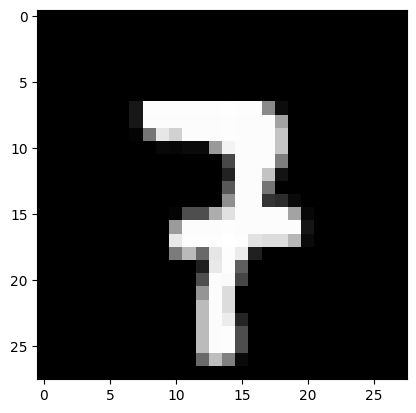

In [9]:
test_prediction(1990, W1, b1, W2, b2, W3, b3)

Model predicted: 3
Actual label: 3


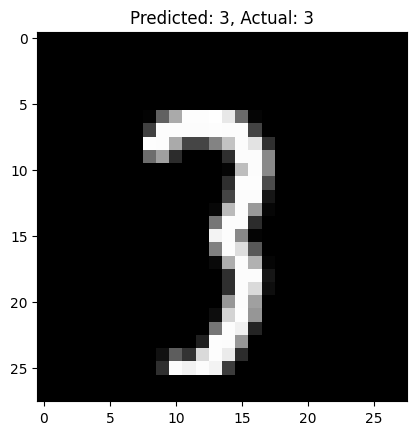

In [16]:
def show_random_prediction(target_digit, X, Y, W1, b1, W2, b2, W3, b3):
    """
    Finds all instances where the model predicted the given target_digit,
    selects one at random, and displays the corresponding image with its actual label.
    """
    predictions = make_prediction(X, W1, b1, W2, b2, W3, b3)

    matching_indices = np.where(predictions == target_digit)[0]

    if len(matching_indices) == 0:
        print(f"No predictions found for digit {target_digit}")
        return

    random_index = random.choice(matching_indices)
    image = X[:, random_index].reshape(28, 28) * 255
    label = Y[random_index]

    print(f"Model predicted: {target_digit}")
    print(f"Actual label: {label}")

    plt.gray()
    plt.imshow(image, interpolation='nearest')
    plt.title(f"Predicted: {target_digit}, Actual: {label}")
    plt.show()

show_random_prediction(3, X_train, Y_train, W1, b1, W2, b2, W3, b3)